# Iterative Model Development Steps with Application to Fashion-MNIST Dataset
- Steps are also outlined in today's [deck](http://bit.ly/2SbsPKX)
- Link to Fashion-MNIST [dataset](https://github.com/zalandoresearch/fashion-mnist)

## Step 1: Understand Different Modeling Approaches
- Model development is an art and science -- you may have done these steps differently. 
- Please let us know what you would have done!

In [1]:
# Standard libraries:
from collections import Counter
import inspect
import os

# Third-party libraries:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, \
                            mean_squared_error, roc_auc_score

# Custom libraries:
import network

In [2]:
np.random.seed(2000)

## Step 2: Understand Business Use Case
Proposed use case -- there may be (many) others:
- **Client**: Online marketplace for buyers and sellers of retail goods

- **Statement of Problem**: Marketplace allows sellers to upload goods and requires an item's description, that's indexed by the platform's search engine. 

- **Question**: Can we improve search results by automatically tagging an item's category for the seller (and surfacing that tag to the platform's search engine)?

- **Business Impact**: Improved search results may affect engagement, conversion and AOV. If AOV increases by 5%, assuming a `$40` AOV and `$200K` revenue/month, our work increases revenue by `$100K`/year.  

What approach would you recommend?

**Approach 1 (v0, today)**: Aim to derive tags based on item's image.

**Approach 2 (outside scope of class)**: Aim to derive tags based on item's description.

**Approach 3 (outside scope of class)**: Aim to derive tags based on ensemble of item's image and description.

## Step 3: Get Access to Data

### Step 3-a: Access Helper Function to Read-in Data
To access the data set, we'll be following instructions under `Loading data with Python` section, outlined below:

In [3]:
# Save location of notebook:
notebook_dir = os.getcwd()
notebook_dir

'/Users/irina/Documents/Stats_404/Stats-404-repo/Class4'

**Step 1**: Clone Fashion-MNIST [repository](https://github.com/zalandoresearch/fashion-mnist)

**Step 2**: Specify path to this direcotry on your local machine:

In [4]:
# Path to repository on my machine:
fashion_mnist_dir = "/Users/irina/Documents/Stats-Related/Fashion-MNIST-repo"

**Step 3**: Change directories to the repository on your local machine:

In [5]:
os.chdir(fashion_mnist_dir)

**Step 4**: Import the helper function to read-in the data

In [6]:
from utils import mnist_reader

### Step 3-b: Read-in Data
Read-in the data using the helper function of data set's repository.

In [7]:
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

In [8]:
X_train.shape

(60000, 784)

In [58]:
# Prevent overflow of computation by dividing by the max value of scale, 
# to be on 0-1 scale, not 0-255:
X_train_normalize = [x/255.0 for x in X_train]

In [10]:
X_test.shape

(10000, 784)

In [11]:
Counter(y_train)

Counter({9: 6000,
         0: 6000,
         3: 6000,
         2: 6000,
         7: 6000,
         5: 6000,
         1: 6000,
         6: 6000,
         4: 6000,
         8: 6000})

In [12]:
# Create dictionary of outcome variable labels, per repository:
label_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

### Step 3-c: EDA of Data

In [13]:
def visualize_image(dataset_x, dataset_y, img_index, y_labels=label_dict):
    """Helper function to visualize image and associated label, for
       specified image in index.
       ---
       Note: Assume image size is 28 x 28.
    """
    plt.imshow(dataset_x[img_index].reshape(28, 28),
               cmap='Greys')
    print(y_labels[dataset_y[img_index]])

Ankle boot


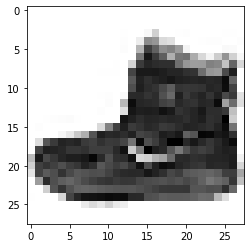

In [14]:
visualize_image(X_train_normalize, y_train, 0)

T-shirt/top


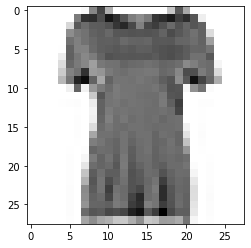

In [15]:
visualize_image(X_train_normalize, y_train, 10)

## Step 4: Determine Data Splits
What are some data splits that you would propose?

In [16]:
# Add outcome column to data set of features, to be able to split dataset
# into training and validation, statifying by outcome variable:
df_tmp = pd.concat([pd.DataFrame(X_train_normalize),
                    pd.DataFrame(y_train, columns=["outcome"])], axis=1)
df_tmp.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,
       ...
             775,       776,       777,       778,       779,       780,
             781,       782,       783, 'outcome'],
      dtype='object', length=785)

In [17]:
df_train, df_valid = train_test_split(df_tmp,
                                      test_size=0.25,
                                      random_state=2019,
                                      stratify=df_tmp['outcome'])

In [18]:
df_train['outcome'].value_counts(sort=False)

0    4500
1    4500
2    4500
3    4500
4    4500
5    4500
6    4500
7    4500
8    4500
9    4500
Name: outcome, dtype: int64

In [19]:
df_valid['outcome'].value_counts(sort=False)

0    1500
8    1500
1    1500
9    1500
2    1500
3    1500
4    1500
5    1500
6    1500
7    1500
Name: outcome, dtype: int64

In [20]:
Counter(y_test)

Counter({9: 1000,
         2: 1000,
         1: 1000,
         6: 1000,
         4: 1000,
         5: 1000,
         7: 1000,
         3: 1000,
         8: 1000,
         0: 1000})

## Step 5: Feature Engineering

Baseline model (v0) will use greyscale images that were rescaled to be on a scale of 0-1 (from 0-255), as features.

Using this assumptions, how many features are there per image?

## Step 6: Estimate a Baseline Model (v0)

In [21]:
y = df_train['outcome']
X = df_train.drop(columns=['outcome'])

In [22]:
X.shape

(45000, 784)

In [23]:
inspect.signature(RandomForestClassifier)

<Signature (n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)>

In [24]:
### --- Step 1: Specify different number of trees in forest, to determine
###             how many to use based on leveling-off of OOB error:
n_trees = [50, 100, 250, 500, 1000, 1500, 2500]

In [25]:
### --- Step 2: Create dictionary to save-off each estimated RF model:
rf_dict = dict.fromkeys(n_trees)

In [26]:
for num in n_trees:
    print(num)
    ### --- Step 3: Specify RF model to estimate:
    rf = RandomForestClassifier(n_estimators=num,
                                min_samples_leaf=30,
                                oob_score=True,
                                random_state=2019,
                                class_weight='balanced',
                                verbose=1)
    ### --- Step 4: Estimate RF model and save estimated model:
    rf.fit(X, y)
    rf_dict[num] = rf

50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   17.6s finished


100


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   35.4s finished


250


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.4min finished


500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  2.9min finished


1000


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  6.1min finished


1500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  9.5min finished


2500


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed: 16.4min finished


*Note:* We could have used [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to perform the optimization, but `GridSearchCV` performs 2+ Fold Cross-Validation that's repeated 3 times.

In [27]:
### --- Save-off model:
# Specify location and name of object to contain estimated model:
model_object_path = os.path.join(notebook_dir, 'rf.joblib')
# Save estimated model to specified location:
dump(rf_dict, model_object_path) 

# Load model:
# rf_dict = load(model_object_path) 

['/Users/irina/Documents/Stats_404/Stats-404-repo/Class4/rf.joblib']

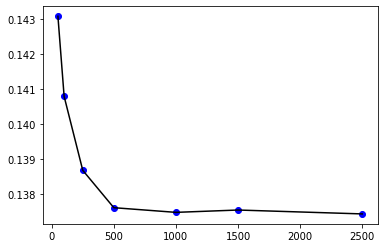

In [28]:
# Compute OOB error per
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
oob_error_list = [None] * len(n_trees)

# Find OOB error for each forest size:
for i in range(len(n_trees)):
    oob_error_list[i] = 1 - rf_dict[n_trees[i]].oob_score_
else:
    # Visulaize result:
    plt.plot(n_trees, oob_error_list, 'bo',
             n_trees, oob_error_list, 'k')

How many trees are enough for our forest?

# Step 7: Interpret Results

In [29]:
# Feature importance plot, modified from: 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
top_num = 20
forest = rf_dict[500]
importances = forest.feature_importances_

# Sort in decreasing order:
indices = np.argsort(importances)[::-1]

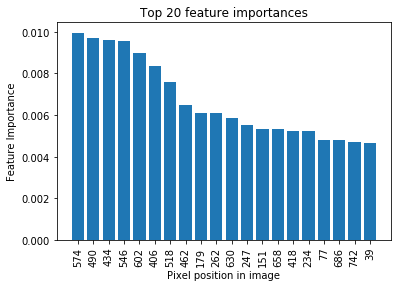

In [30]:
# Plot the feature importances of the forest
ax = plt.gca()
plt.title(f"Top {top_num} feature importances")
plt.bar(range(top_num), importances[indices[0:top_num]])
plt.xticks(range(top_num))
ax.set_xticklabels(indices[0:top_num], rotation = 90)
ax.set_xlabel("Pixel position in image")
ax.set_ylabel("Feature Importance")
plt.show()

How can you decided how many top X features are important?

## Step 8: Evaluate Performance

### Step 8a: Evaluate Performance on In-Sample Data
Evaluate performance on in-sample data, to see wat the "best-possible" performance is, on data that the model's seen.


In [31]:
y_pred_train = forest.predict(X)
y_pred_train[0:5]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.7s finished


array([2, 1, 0, 4, 3], dtype=uint8)

In [32]:
y_pred_train_probs = pd.DataFrame(forest.predict_proba(X))
y_pred_train_probs.head()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.8s finished


,0,1,2,3,4,5,6,7,8,9
0,0.004653,0.005502,0.857476,0.002557,0.039973,0.002692,0.080528,0.000282,0.004449,0.001890
1,0.004345,0.967976,0.000216,0.017679,0.005040,0.001031,0.002384,0.000000,0.001292,0.000036
2,0.560582,0.000822,0.004595,0.022059,0.007729,0.000000,0.402047,0.000000,0.001910,0.000256
3,0.003820,0.001461,0.215259,0.001763,0.683101,0.000314,0.087834,0.000000,0.005451,0.000996
4,0.002132,0.002174,0.000361,0.994120,0.000337,0.000108,0.000175,0.000000,0.000593,0.000000


#### Evaluate Performance via Confusion Matrix

In [33]:
conf_mat = confusion_matrix(y_true=y,
                            y_pred=y_pred_train)
conf_mat

array([[3934,    3,   61,  172,   25,    5,  245,    0,   55,    0],
       [  10, 4305,   43,  115,    6,    2,   17,    0,    2,    0],
       [  18,    1, 3737,   45,  498,    3,  168,    0,   30,    0],
       [  84,    9,   46, 4160,  116,    0,   75,    0,   10,    0],
       [   5,    4,  256,  159, 3924,    0,  136,    0,   15,    1],
       [   0,    0,    0,    1,    0, 4242,    2,  166,   25,   64],
       [ 669,    6,  514,  114,  351,    2, 2762,    0,   82,    0],
       [   0,    0,    0,    0,    0,   56,    0, 4222,    6,  216],
       [   8,    3,   20,   18,   22,   16,   36,   13, 4362,    2],
       [   0,    0,    0,    3,    0,   35,    3,  143,    7, 4309]])

In [34]:
# To have columns be in correct order:
class_names = [label_dict[x] for x in range(10)]

In [35]:
conf_df = pd.DataFrame(conf_mat, class_names, class_names)
conf_df

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,3934,3,61,172,25,5,245,0,55,0
Trouser,10,4305,43,115,6,2,17,0,2,0
Pullover,18,1,3737,45,498,3,168,0,30,0
Dress,84,9,46,4160,116,0,75,0,10,0
Coat,5,4,256,159,3924,0,136,0,15,1
Sandal,0,0,0,1,0,4242,2,166,25,64
Shirt,669,6,514,114,351,2,2762,0,82,0
Sneaker,0,0,0,0,0,56,0,4222,6,216
Bag,8,3,20,18,22,16,36,13,4362,2
Ankle boot,0,0,0,3,0,35,3,143,7,4309


In [36]:
conf_df_pct = conf_df/conf_df.sum(axis=1)
round(conf_df_pct, 2)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,0.87,0.00,0.01,0.04,0.01,0.00,0.05,0.00,0.01,0.00
Trouser,0.00,0.96,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00
Pullover,0.00,0.00,0.83,0.01,0.11,0.00,0.04,0.00,0.01,0.00
Dress,0.02,0.00,0.01,0.92,0.03,0.00,0.02,0.00,0.00,0.00
Coat,0.00,0.00,0.06,0.04,0.87,0.00,0.03,0.00,0.00,0.00
Sandal,0.00,0.00,0.00,0.00,0.00,0.94,0.00,0.04,0.01,0.01
Shirt,0.15,0.00,0.11,0.03,0.08,0.00,0.61,0.00,0.02,0.00
Sneaker,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.94,0.00,0.05
Bag,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.97,0.00
Ankle boot,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.00,0.96


What does the confusion matrix tell us about our model?

Aside:
- `seaborn` [gallery](https://seaborn.pydata.org/examples/index.html) for visualizations
- [Conditional highlighting](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html) of pandas dataframes

#### Evaluate Performance via F1-score
We have a multi-class outcome, let's use an associated F1-score, per:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html and https://medium.com/@ramit.singh.pahwa/micro-macro-precision-recall-and-f-score-44439de1a044

In [37]:
# Class-level performance:
f1_score(y_true=y,
         y_pred=y_pred_train,
         average='macro')

0.8862739486087194

In [38]:
# Overall performance across all classes:
f1_score(y_true=y,
         y_pred=y_pred_train,
         average='micro')

0.8879333333333332

Is our F1-score surprising?

What do we think about the model?

# Step 9: Fit An Alternative Model (v1)
**Alternative Model**: Estimate a fully connected neural network with 1 hidden layer to try ot predict category of image... in (base) Python (!).

**Motivation**: 
- Aim to understand what's happening behind-the-scenes with simple NN model first
- Learning + practicing concepts, not syntax
- Easier to debug

# Before we tackle Neural Networks in (base) Python... Brief Introduction to OOP  
Reference: https://realpython.com/python3-object-oriented-programming/

- **Procedural programming**
  - e.g. this notebook
- **Object Oriented Programming (OOP)**
  - e.g. person, with behaviors such as 'attending class'
- OOP components:
  - Classes contain properties (e.g. 'attending class')
  - Instance of class (e.g. person 1, person 2, etc.)
  - Class inheritance (outside scope of today's lecture)


In [39]:
class Person():
    """Class person"""
    
    def __init__(self, name):
        """Class requires that each Person has a name."""
        self.name = name

In [40]:
instructor = Person('Irina')
instructor.name

'Irina'

In [41]:
TA = Person('Theja')
TA.name

'Theja'

In [42]:
type(instructor)

__main__.Person

# (Back to) Step 9: Fit An Alternative Model (v1)
Reference: http://neuralnetworksanddeeplearning.com/chap1.html and
simplified `network.py` code from repository:
https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network.py


In [43]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

#### Reshape Dataset to Format Expected by Fully Connected NN
Format:
- list of same length as number of images in (training) data set
- each entry in list is a tuple of length 2, containing (features, outcome) of a given image
- features are an 784 x 1 Numpy Ndarray
- outcome is 10 x 1 Numpy Ndarray

In [44]:
num_rows = X.shape[0]
training_data = [None]*num_rows
for i in range(num_rows):
    if i % 15000 == 0:
        print(i)
    # Create ndarray for each row of X:
    tmp_x = pd.DataFrame(X.iloc[i]).values
    # Create ndarray of length 10 for each value of y:
    tmp_y = pd.DataFrame(np.zeros(10)).values
    tmp_y[y[i]] = y[i]
    # Create tuple for each image:
    training_data[i] = (tmp_x, tmp_y)

0
15000
30000


#### Define the Fully Connected NN and its Estimation
- Please see `network.py` in this repository for commented version of the code.

<Walk through of `network.py`>

In [45]:
# Network specs: 
#     28*28 neurons in input layer, 
#     30 in hidden layer, 
#     predicting 1 of 10 classes in output layer:
random.seed(2019)
net = network.Network([784, 30, 10])

In [46]:
res = net.SGD(training_data, learning_rate=3.0)

0.17177777777777778
0.14644444444444443
0.10946666666666667
0.13368888888888888
0.16677777777777777
0.2038
0.2454
0.2773555555555556
0.29355555555555557
0.3083111111111111
0.32308888888888887
0.33668888888888887
0.3490888888888889
0.36002222222222224
0.3702888888888889
0.3805777777777778
0.38997777777777776
0.39757777777777775
0.40313333333333334
0.4078
0.4106888888888889
0.41335555555555553
0.4167777777777778
0.41915555555555556
0.42146666666666666
0.4236666666666667
0.4255555555555556
0.4284
0.43033333333333335
0.4325333333333333
0.43464444444444444
0.4365777777777778
0.4381111111111111
0.44
0.44137777777777776
0.44235555555555556
0.44384444444444443
0.4447111111111111
0.4457111111111111
0.4464222222222222
0.44726666666666665
0.44755555555555554
0.44793333333333335
0.4487111111111111
0.4491777777777778
0.4494888888888889
0.44993333333333335
0.45082222222222224
0.45126666666666665
0.4523111111111111
0.4530888888888889
0.4533111111111111
0.4537777777777778
0.45453333333333334
0.4551777

Final accuracy: ~53%

Note: 
- Convergence is not monotonic
- Sensitive to initial conditions

#### Ad-hoc (Mis)classifications Check
- Recall: We're using sigmoid, not softmax activation function

In [48]:
img_number = 10
res[img_number].round(2)

array([[0.  ],
       [0.  ],
       [0.03],
       [0.  ],
       [0.  ],
       [0.63],
       [0.06],
       [0.07],
       [1.  ],
       [0.  ]])

In [49]:
img_number = 0
predicted = label_dict[np.argmax(res[img_number])]
observed = label_dict[y[img_number]]
(predicted, observed)

('Pullover', 'Pullover')

#### Evaluate Performance via Confusion Matrix

In [50]:
y_pred_train_nn = [np.argmax(x) for x in res]

In [51]:
conf_mat_nn = confusion_matrix(y_true=y,
                               y_pred=y_pred_train_nn)
conf_mat_nn

array([[   0,    0,    5,  586,   14,   15, 3720,    0,  144,   16],
       [   0,    0,    3, 2823,   76,  624,  943,    0,    9,   22],
       [   0,    0,  210,   36,  133,    7, 3973,    0,  140,    1],
       [   0,    0,    2, 3800,  197,    6,  434,    1,   55,    5],
       [   0,    0,   16,  152, 1106,    3, 3162,    0,   60,    1],
       [   0,    0,    3,    1,    3, 3023,    8, 1040,   83,  339],
       [   0,    0,   29,  226,  154,   12, 3897,    0,  178,    4],
       [   0,    0,    0,    0,    0,  522,    1, 3587,   17,  373],
       [   0,    0,    1,   33,   12,   38,  143,   26, 4232,   15],
       [   0,    0,    0,    0,    1,   65,    0,  273,    6, 4155]])

In [52]:
conf_df_nn = pd.DataFrame(conf_mat_nn, class_names, class_names)
conf_df_pct_nn = conf_df_nn/conf_df_nn.sum(axis=1)
round(conf_df_pct_nn, 2)

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,0.0,0.0,0.00,0.13,0.00,0.00,0.83,0.00,0.03,0.00
Trouser,0.0,0.0,0.00,0.63,0.02,0.14,0.21,0.00,0.00,0.00
Pullover,0.0,0.0,0.05,0.01,0.03,0.00,0.88,0.00,0.03,0.00
Dress,0.0,0.0,0.00,0.84,0.04,0.00,0.10,0.00,0.01,0.00
Coat,0.0,0.0,0.00,0.03,0.25,0.00,0.70,0.00,0.01,0.00
Sandal,0.0,0.0,0.00,0.00,0.00,0.67,0.00,0.23,0.02,0.08
Shirt,0.0,0.0,0.01,0.05,0.03,0.00,0.87,0.00,0.04,0.00
Sneaker,0.0,0.0,0.00,0.00,0.00,0.12,0.00,0.80,0.00,0.08
Bag,0.0,0.0,0.00,0.01,0.00,0.01,0.03,0.01,0.94,0.00
Ankle boot,0.0,0.0,0.00,0.00,0.00,0.01,0.00,0.06,0.00,0.92


Anything jump out as reasonable misclassification?

Anything jump out as egregious misclassification?

In [53]:
# Compare with confusion matrix from RF:
round(conf_df_pct, 2)


,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,0.87,0.00,0.01,0.04,0.01,0.00,0.05,0.00,0.01,0.00
Trouser,0.00,0.96,0.01,0.03,0.00,0.00,0.00,0.00,0.00,0.00
Pullover,0.00,0.00,0.83,0.01,0.11,0.00,0.04,0.00,0.01,0.00
Dress,0.02,0.00,0.01,0.92,0.03,0.00,0.02,0.00,0.00,0.00
Coat,0.00,0.00,0.06,0.04,0.87,0.00,0.03,0.00,0.00,0.00
Sandal,0.00,0.00,0.00,0.00,0.00,0.94,0.00,0.04,0.01,0.01
Shirt,0.15,0.00,0.11,0.03,0.08,0.00,0.61,0.00,0.02,0.00
Sneaker,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.94,0.00,0.05
Bag,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.97,0.00
Ankle boot,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.03,0.00,0.96


Should we refactor this code:
```
conf_df_nn = pd.DataFrame(conf_mat_nn, class_names, class_names)
conf_df_pct_nn = conf_df_nn/conf_df_nn.sum(axis=1)
round(conf_df_pct_nn, 2)
```
into a function?

#### Evaluate Performance via F1-score

In [54]:
# Class-level performance:
f1_score(y_true=y,
         y_pred=y_pred_train_nn,
         average='macro')

0.46714327387303467

In [55]:
# Class-level performance:
f1_score(y_true=y,
         y_pred=y_pred_train_nn,
         average='micro')

0.5335555555555556

Are we suprised by these results?

What do we think about the model?

![Warning](./images/warning.png) Just because we iterated on the model, model improvement is not guaranteed (!).

Should we ensemble current NN with RF model? Why?

What are some approaches to improve NN model performance?

What are alternative approaches for next model iteration?

# Back to the Business Question

**Use case**: Help tag item category to improve search results.

Models are not perfect and model may make a mistake. Let's think about misclassification rate... Which is more costly to seller?

Which is more costly to buyer?

Ideas to improve recommendations using current model framework (RF or NN)?

Hint: can we leverage probabilities?

Hint: can we leverage category hierarchy?